# Modeling HFTER Full Core

This notebook is intended to demonstrate how to use ROBIN3's [Python API](../pythonapi/index.rst) to simulate a 2-D HFTER full core. 

In [12]:
%matplotlib inline
from pprint import pprint
from copy import deepcopy
import numpy as np
import robin3
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
robin3.config.USE_TQDM_NOTEBOOK = True
robin3.config.NUM_DIVISIONS_MESHING_REFLECTOR = 10

## Defining Materials

In [2]:
materials = [
    {"name": "U_Al",
    "elements": ["UO2_90.0"],
    "weight_percents": [1.0],
    "density": 10.0},
    {"name": "UO2_3",
    "elements": ["UO2_3.0"],
    "weight_percents": [1.0],
    "density": 10.4},
    {"name": "Al305",
    "elements": ["Fe-nat", "Ni-nat", "Si-nat", "Cu-nat", "Ti-nat", "Al-nat"],
    "weight_percents": [0.0045, 0.009, 0.0017, 0.001, 0.001, 0.9828],
    "density": 3.9},
    {"name": "LT24",
    "elements": ["Mg-nat", "Si-nat", "Cu-nat", "Al-nat"],
    "weight_percents": [0.007, 0.006, 0.003, 0.984],
    "density": 3.9},
    {"name": "BE",
    "elements": ["Be-nat"],
    "weight_percents": [1.0],
    "density": 0.5},
    {"name": "CO",
    "elements": ["Co-59"],
    "weight_percents": [1.0],
    "density": 5.9},
    {"name": "N",
    "elements": ["N-nat"],
    "weight_percents": [1.0],
    "density": 0.001},
    {"name": "PMOD",
    "elements": ["H-H2O", "O-nat"],
    "number_densities": [0.0468, 0.0234]},
]
# pprint(materials)

## Defining Structures

In [3]:
fuel_structure = {
    "name": "FUS",
    "meshing": {"type": "SECTORS", "num_azimuths": 18, "radii": [0.35]},
    "primitives": [{"type": "CIRCLE", "radius": r} for r in 
                   [0.60, 0.70, 0.90, 0.95, 1.00, 1.05, 1.25, 1.30, 1.35, 1.40, 
                    1.60, 1.65, 1.70, 1.75, 1.95, 2.00, 2.05, 2.10, 2.30, 2.35, 
                    2.40, 2.45, 2.65, 2.70, 2.75, 2.80, 3.00, 3.15]],
    "regions": [{"material": m, "space": s} for m,  s in zip(
        ["LT24", "LT24", "U_Al", "LT24", "LT24", "U_Al", "LT24", "LT24", 
         "U_Al", "LT24", "LT24", "U_Al", "LT24", "LT24", "U_Al", "LT24", 
         "LT24", "U_Al"], 
        ["2-1", "4-3", "5-4", "6-5", "8-7", "9-8", "10-9", "12-11", 
         "13-12","14-13","16-15","17-16","18-17","20-19","21-20",
         "22-21","24-23","25-24","26-25","26-25"])]
}
be_structure = {
    "name": "BES",
    "meshing": {
        'type': 'RECTANGLES',
        'num_divisions_x': 10,
        'num_divisions_y': 10,
        'xmin': -5.0,
        'xmax':  5.0,
        'ymin': -5.0,
        'ymax':  5.0
    },
    "primitives": [
        {"type": "CIRCLE", "radius": 0.85},
        {"type": "CIRCLE", "radius": 1.0},
        {"type": "POLYGON",
         "vertexes": [{"x": -5.0, "y": -5.0},
                      {"x": -5.0, "y":  5.0},
                      {"x":  5.0, "y": -5.0},
                      {"x":  5.0, "y":  5.0}]}
    ],
    "regions": [{"material": "BE", "space": "1"},
                {"material": "AIR", "space": "2-1"},
                {"material": "BE", "space": "3-2"}]
}
crd_structure = {
    "name": "CRS",
    "meshing": {"type": "SECTORS", "num_azimuths": 18, "radii": [1.0, 1.5, 1.75]},
    "primitives": [{"type": "CIRCLE", "radius": r} for r in 
                   [1.95, 2.1, 2.25, 2.4, 2.7, 2.85, 3.0, 3.15]],
    "regions": [{"material": m, "space": s} for m,  s in zip(
            ["LT24", "LT24", "CO", "LT24", "LT24"], ["2-1", "4-3", "5-4", "6-5", "8-7"])]
}
co_structure = {
    "name": "COS",
    "meshing": {"type": "SECTORS", "num_azimuths": 18, "radii": [1.0, 1.5, 2.1, 3.0]},
    "primitives": [{"type": "CIRCLE", "radius": r} for r in [1.75, 1.8, 2.3, 2.35, 2.75, 3.15]],
    "regions": [{"material": m, "space": s} for m,  s in zip(["SS304", "AIC", "SS304", "AIC"], 
                                                             ["2-1", "3-2", "4-3", "6-5"])]
}
structures = [fuel_structure, be_structure, crd_structure, co_structure]
# pprint(structures)

## Defining Assemblies

In [4]:
assemblies = [{"name": name + "A",
               "type": "HEXAGON",
               "pitch": 6.25,
               "cell_pitch": 6.25,
               "cell_map": [name + "S"]} 
               for name in ["BE", "FU", "CR", "CO"]]
# pprint(assemblies)

## Defining Core

In [5]:
def hexagon(pitch, center):
    p = pitch / 2
    sr3 = np.sqrt(3.0)
    x, y = center
    return {
        "type": "POLYGON",
        "vertexes": [{"x":  -p + x, "y":  p/sr3 + y},
                     {"x":  -p + x, "y": -p/sr3 + y},
                     {"x": 0.0 + x, "y": -pitch/sr3 + y},
                     {"x":   p + x, "y": -p/sr3 + y},
                     {"x":   p + x, "y":  p/sr3 + y},
                     {"x": 0.0 + x, "y":  pitch/sr3 + y}]
    } 

def square(pitch, center):
    p = pitch / 2
    x, y = center
    return {
        "type": "POLYGON",
        "vertexes": [{"x": -p + x, "y": -p + y},
                     {"x":  p + x, "y": -p + y},
                     {"x":  p + x, "y":  p + y},
                     {"x": -p + x, "y":  p + y}]
    }

x, y = -25.0, 0.0
core = {
    "name": "HFTER",
    "type": "HEXAGON",
    "symmetry": 1,
    "assembly_map":                  [   "",   "",   "",   "",   "",   "",   "",
                                      "","BEA","BEA","BEA","BEA","BEA","BEA",   "",
                                   "","BEA","BEA","BEA","CRA","BEA","BEA","BEA",   "",
                                "","BEA","BEA","FUA","FUA","FUA","FUA","BEA","BEA",   "",
                           "BEA","BEA","CRA","FUA","CRA","BEA","CRA","FUA","CRA","BEA",   "",
                        "BEA",   "",   "","COA","BEA","FUA","FUA","BEA","FUA","BEA","BEA",   "",
                     "BEA",   "",   "",   "","FUA","FUA","BEA","FUA","COA","FUA","BEA","BEA",   "",
                        "BEA",   "",   "","COA","BEA","FUA","FUA","BEA","FUA","BEA","BEA",   "",
                           "BEA","BEA","CRA","FUA","CRA","BEA","CRA","FUA","CRA","BEA",   "",
                                "","BEA","BEA","FUA","FUA","FUA","FUA","BEA","BEA",   "",
                                   "","BEA","BEA","BEA","CRA","BEA","BEA","BEA",   "",
                                      "","BEA","BEA","BEA","BEA","BEA","BEA",   "",
                                         "",   "",   "",   "",   "",   "",   ""],
    "reflector": {
        "primitives": [
            hexagon(6.25, (-28.125,  5.4127)),
            hexagon(6.25, (-21.875,  5.4127)),
            hexagon(6.25, (-31.25,   0.0)),
            hexagon(6.25, (x, y)),
            hexagon(6.25, (-18.75,   0.0)),
            hexagon(6.25, (-28.125, -5.4127)),
            hexagon(6.25, (-21.875, -5.4127)),
            
            {"type": "CIRCLE", "radius":  6.4, "center": {"x": x, "y": y}},
            {"type": "CIRCLE", "radius":  6.0, "center": {"x": x, "y": y}},
            {"type": "CIRCLE", "radius": 4.65, "center": {"x": x, "y": y}},
            {"type": "CIRCLE", "radius": 4.25, "center": {"x": x, "y": y}},
            
            square(5.61, (x, y)),
            square(5.31, (x, y)),
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -0.66375 + x, "y": 1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x": -0.66375 + x, "y": 1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x": -0.66375 + x, "y": 1.99125 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  0.66375 + x, "y": 1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x":  0.66375 + x, "y": 1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x":  0.66375 + x, "y": 1.99125 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -1.99125 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x": -1.99125 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x": -1.99125 + x, "y": 0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -0.66375 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x": -0.66375 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x": -0.66375 + x, "y": 0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  0.66375 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.411,  "center": {"x":  0.66375 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4025, "center": {"x":  0.66375 + x, "y": 0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  1.99125 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x":  1.99125 + x, "y": 0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x":  1.99125 + x, "y": 0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -1.99125 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x": -1.99125 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x": -1.99125 + x, "y": -0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -0.66375 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.411,  "center": {"x": -0.66375 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4025, "center": {"x": -0.66375 + x, "y": -0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  0.66375 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.411,  "center": {"x":  0.66375 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4025, "center": {"x":  0.66375 + x, "y": -0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  1.99125 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x":  1.99125 + x, "y": -0.66375 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x":  1.99125 + x, "y": -0.66375 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x": -0.66375 + x, "y": -1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x": -0.66375 + x, "y": -1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x": -0.66375 + x, "y": -1.99125 + y}},
            
            {"type": "CIRCLE", "radius": 0.475,  "center": {"x":  0.66375 + x, "y": -1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.418,  "center": {"x":  0.66375 + x, "y": -1.99125 + y}},
            {"type": "CIRCLE", "radius": 0.4095, "center": {"x":  0.66375 + x, "y": -1.99125 + y}},
            
            {"type": "CIRCLE", "radius": 9.0, "center": {"x":  21.875, "y":  37.8887}},
            {"type": "CIRCLE", "radius": 9.0, "center": {"x": -21.875, "y": -37.8887}},
            {"type": "CIRCLE", "radius": 5.0, "center": {"x": -40.625, "y":  23.3549}},
            {"type": "CIRCLE", "radius": 5.0, "center": {"x":  40.625, "y": -23.3549}},
            
            {"type": "CIRCLE", "radius": 65.625}
        ],
        "regions": [
            {"material": "Al305", "space":  '(1|2|3|4|5|6|7)-8'},
            {"material": "LT24",  "space":  '8-9'},
            {"material": "N",     "space":  '9-10'},
            {"material": "LT24",  "space":  '10-11'},
            {"material": "PMOD",  "space":  '11-12'},
            {"material": "LT24",  "space":  '12-13'},
            {"material": "PMOD",  "space":  '13-(14|17|20|23|26|29|32|35|38|41|44|47)'},
            {"material": "ZIRC4", "space":  '14-15'},
            {"material": "HE",    "space":  '15-16'},
            {"material": "UO2_3", "space":  '16', "tag": "fuel_1"},
            {"material": "ZIRC4", "space":  '17-18'},
            {"material": "HE",    "space":  '18-19'},
            {"material": "UO2_3", "space":  '19', "tag": "fuel_2"},
            {"material": "ZIRC4", "space":  '20-21'},
            {"material": "HE",    "space":  '21-22'},
            {"material": "UO2_3", "space":  '22', "tag": "fuel_3"},
            {"material": "ZIRC4", "space":  '23-24'},
            {"material": "HE",    "space":  '24-25'},
            {"material": "UO2_3", "space":  '25', "tag": "fuel_4"},
            {"material": "ZIRC4", "space":  '26-27'},
            {"material": "HE",    "space":  '27-28'},
            {"material": "UO2_3", "space":  '28', "tag": "fuel_5"},
            {"material": "ZIRC4", "space":  '29-30'},
            {"material": "HE",    "space":  '30-31'},
            {"material": "UO2_3", "space":  '31', "tag": "fuel_6"},
            {"material": "ZIRC4", "space":  '32-33'},
            {"material": "HE",    "space":  '33-34'},
            {"material": "UO2_3", "space":  '34', "tag": "fuel_7"},
            {"material": "ZIRC4", "space":  '35-36'},
            {"material": "HE",    "space":  '36-37'},
            {"material": "UO2_3", "space":  '37', "tag": "fuel_8"},
            {"material": "ZIRC4", "space":  '38-39'},
            {"material": "HE",    "space":  '39-40'},
            {"material": "UO2_3", "space":  '40', "tag": "fuel_9"},
            {"material": "ZIRC4", "space":  '41-42'},
            {"material": "HE",    "space":  '42-43'},
            {"material": "UO2_3", "space":  '43', "tag": "fuel_10"},
            {"material": "ZIRC4", "space":  '44-45'},
            {"material": "HE",    "space":  '45-46'},
            {"material": "UO2_3", "space":  '46', "tag": "fuel_11"},
            {"material": "ZIRC4", "space":  '47-48'},
            {"material": "HE",    "space":  '48-49'},
            {"material": "UO2_3", "space":  '49', "tag": "fuel_12"},
            
            {"material": "AIR",   "space":  '50', "tag": "loop_1"},
            {"material": "AIR",   "space":  '51', "tag": "loop_2"},
            {"material": "AIR",   "space":  '52', "tag": "loop_3"},
            {"material": "AIR",   "space":  '53', "tag": "loop_4"},
            
            {"material": "Al305", "space": '54-50-51-52-53-(1|2|3|4|5|6|7)'}
        ]
    }
}

## Defining State Points

In [6]:
state_points = {
    "boron_concentration": 0,
    "moderator_temperature": 400,
    "fuel_temperature": 468,
    "system_pressure": 1.0
}

## Composing a Input Model

In [7]:
model = {
    "materials": materials,
    "structures": structures,
    "assemblies": assemblies,
    "core": core,
    "state_points": state_points,
}
import json
with open('hfter.json', 'w') as f:
    json.dump(model, f)

## Visualizing Input Model

Displaying different kinds of assemblies with fine meshes one by one by using [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst):

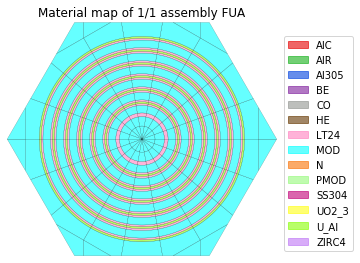

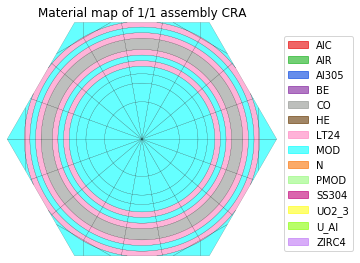

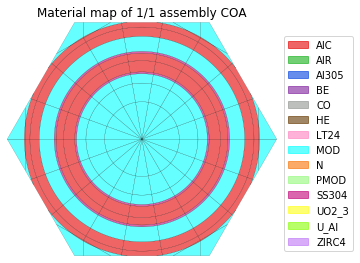

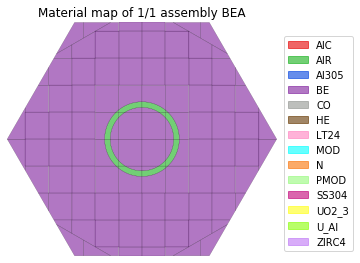

In [8]:
for name in ["FUA", "CRA", "COA", "BEA"]:
    plotter = robin3.Plotter(model, assembly=name)
    fig = plotter.plot_geometry(show_meshes=True)

Displaying the full core.

In [13]:
plotter = robin3.Plotter(model)

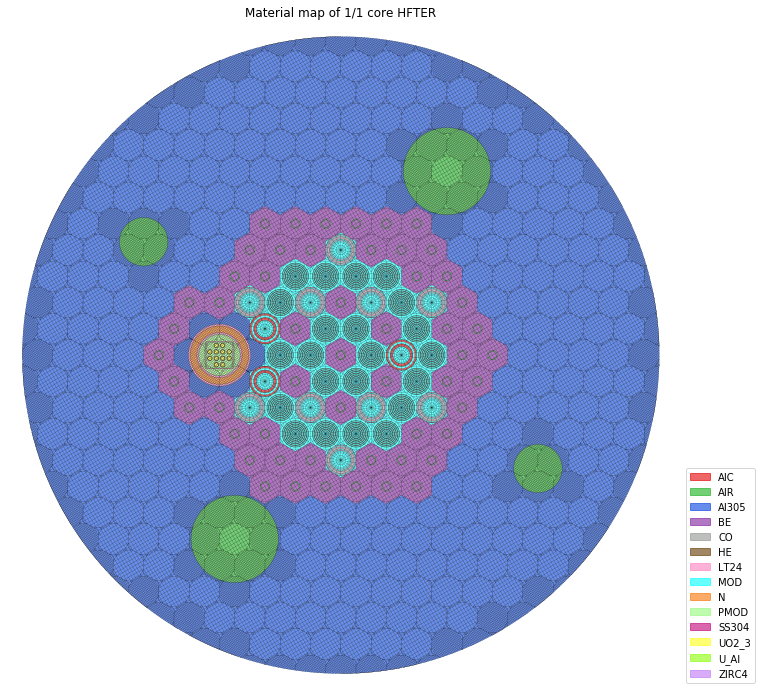

In [14]:
fig = plotter.plot_geometry(show_meshes=True)

Displaying the tagged regions.

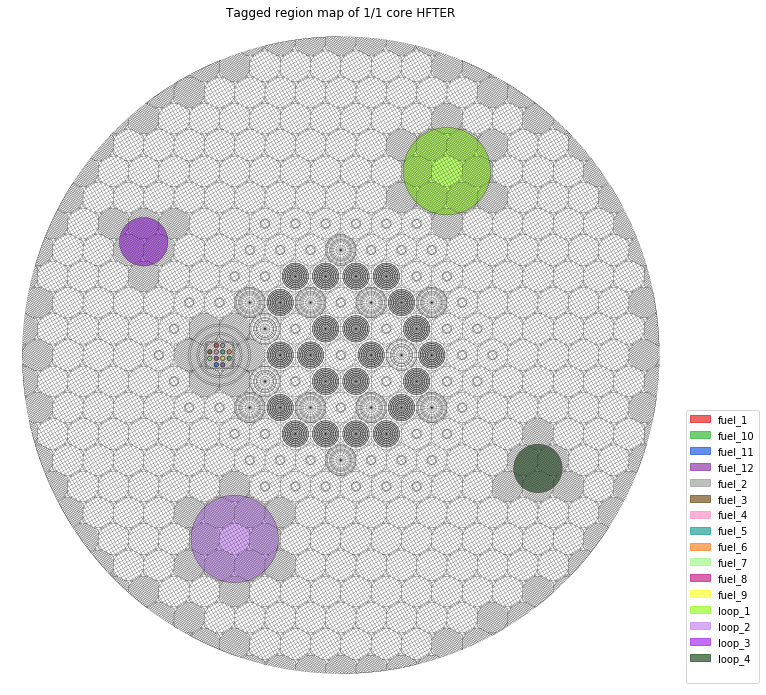

In [16]:
fig = plotter.plot_tagged_regions(show_meshes=True)

## Run ROBIN3

Running ROBIN3 from Python can be done using the [robin3.run()](../pythonapi/generated/robin3.run.rst) function. This function allows you to use GPU by setting use_GPU=True if it needed, GPU will significantly reduce the running time.

In [17]:
result = robin3.run(model, use_gpu=True)
print(result)

The [robin3.run()](../pythonapi/generated/robin3.run.rst) function return a [robin3.ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst) instance which can be initialized from the result file as well. All the result data can be accessed by the result_data attribute, and the result data are saved by a HDF5 file named by
result_file attribute, summary result data such as keff can be inspected by method summary which return a pandas DataFrame.

In [8]:
result = robin3.ResultProcessor('HFTER.h5')
df = result.summary()
print(df)

   burnup    tmo    tfu  bor      keff  peak_pin_power  std_pin_power
0     0.0  400.0  468.0  0.0  1.099381        1.414226       0.092833


## Result Visualization

Result visualization from Python can be done using a [robin3.Plotter](../pythonapi/generated/robin3.Plotter.rst) instance generate by [ResultProcessor](../pythonapi/generated/robin3.ResultProcessor.rst)'s method generate_plotter.

In [9]:
plotter = result.generate_plotter()

Displaying the distribution of mesh fluxes in fine mesh level for each groups. 

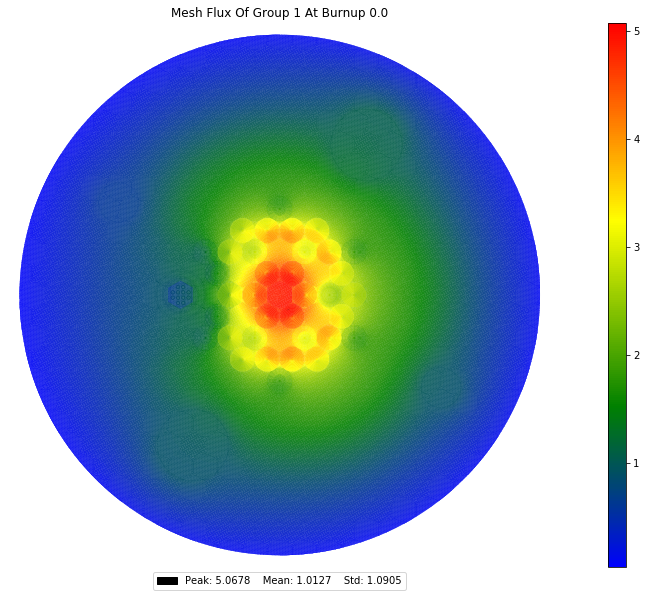

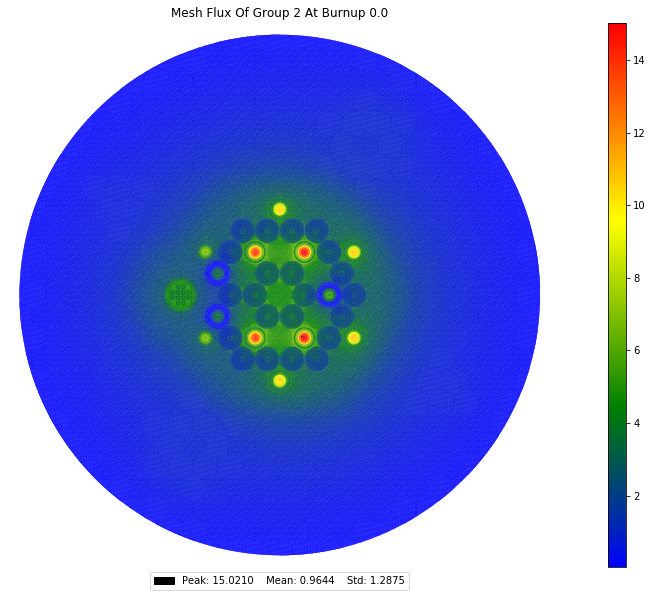

In [13]:
for g in [1, 2]:
    fig = plotter.plot_mesh_flux(group=g)

We can get the neutron fluxes with energy in the tagged regions that we interested and plot them.

In [14]:
result.neutron_fluxes_in_tagged_regions()

average     fuel_1    fuel_10    fuel_11    fuel_12  \
1.000000e+07   1.181657   2.346848   2.801926   2.341317   2.554049   
6.065500e+06   4.939041   9.456726  11.316919   9.432179  10.302800   
3.679000e+06  10.740513  19.687309  23.624846  19.635372  21.465755   
2.231000e+06  14.864783  20.736116  24.617075  20.676361  22.498079   
1.353000e+06  14.261462  18.575993  22.173262  18.519505  20.218081   
...                 ...        ...        ...        ...        ...   
2.500000e-02   0.357770   2.179163   2.152806   2.174328   2.185994   
2.000000e-02   0.307517   1.855390   1.833720   1.851373   1.861594   
1.500000e-02   0.241685   1.424180   1.408160   1.421202   1.429250   
1.000000e-02   0.158911   0.880879   0.871386   0.879153   0.884236   
4.999999e-03   0.058624   0.260636   0.257931   0.260219   0.261712   

                 fuel_2     fuel_3     fuel_4     fuel_5     fuel_6  \
1.000000e+07   2.559473   2.189338   2.565511   2.767917   2.803910   
6.065500e+06  10.326818   8.768138  10.304665  11.145182  11.326204   
3.679000e+06  21.516588  18.177279  21.276688  23.069859  23.644939   
2.231000e+06  22.557560  19.158150  21.970524  23.767563  24.639736   
1.353000e+06  20.273882  17.090719  19.577467  21.242025  22.194212   
...                 ...        ...        ...        ...        ...   
2.500000e-02   2.193426   2.132280   2.010011   2.034331   2.157996   
2.000000e-02   1.867959   1.815191   1.700536   1.722875   1.838691   
1.500000e-02   1.434204   1.393043   1.297801   1.316687   1.412609   
1.000000e-02   0.887412   0.861335   0.799661   0.812998   0.874763   
4.999999e-03   0.262758   0.254650   0.237267   0.242188   0.259302   

                 fuel_7     fuel_8     fuel_9     loop_1     loop_2    loop_3  \
1.000000e+07   2.187616   2.558327   2.766204   0.613543   0.530458  0.118943   
6.065500e+06   8.761382  10.274400  11.136339   2.653686   2.279284  0.546066   
3.679000e+06  18.163063  21.218227  23.049927   5.976466   5.111004  1.424723   
2.231000e+06  19.143606  21.922619  23.744740  11.394870   9.701862  3.090261   
1.353000e+06  17.076199  19.537634  21.219782  12.344359  10.475943  3.935937   
...                 ...        ...        ...        ...        ...       ...   
2.500000e-02   2.134463   2.019303   2.033442   0.241240   0.224623  0.173668   
2.000000e-02   1.817643   1.709829   1.722053   0.206555   0.191958  0.142788   
1.500000e-02   1.395578   1.306428   1.315910   0.152547   0.141615  0.103433   
1.000000e-02   0.863524   0.806441   0.812292   0.090678   0.083993  0.059477   
4.999999e-03   0.255655   0.240140   0.241786   0.039255   0.035644  0.017756   

                loop_4  
1.000000e+07  0.170373  
6.065500e+06  0.797534  
3.679000e+06  2.092387  
2.231000e+06  4.552914  
1.353000e+06  5.852490  
...                ...  
2.500000e-02  0.158880  
2.000000e-02  0.129031  
1.500000e-02  0.092842  
1.000000e-02  0.053094  
4.999999e-03  0.015418  

[69 rows x 17 columns]

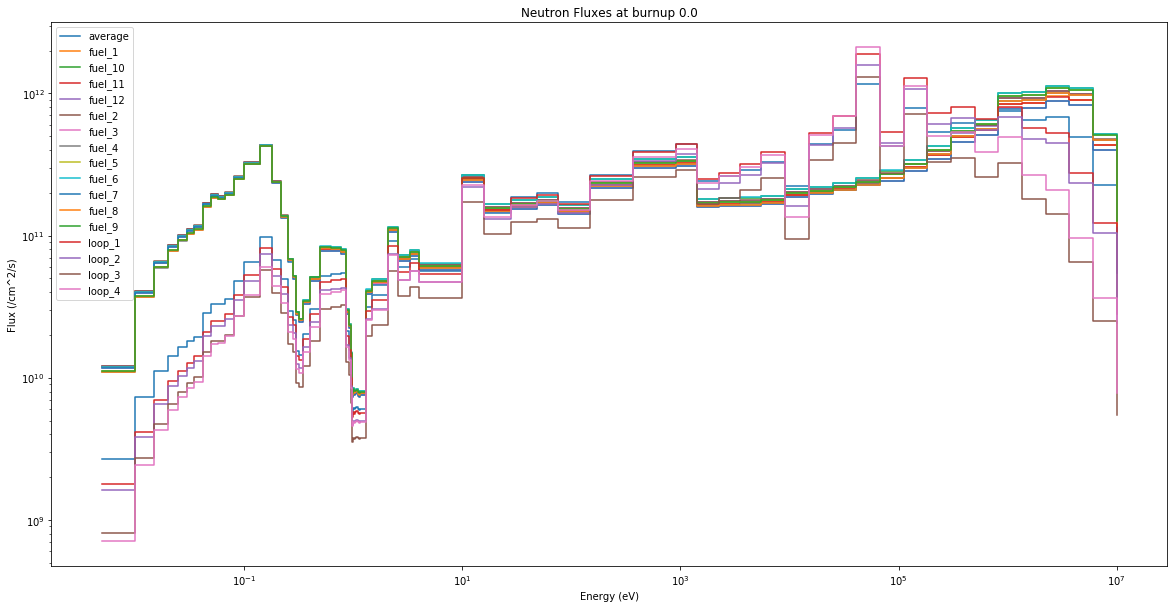

In [15]:
fig = plotter.plot_neutron_fluxes_in_tagged_regions()